# Exercise VIII: K-Means Clustering and PCA

In this exercise, we will try to identify subtypes of ASD using [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) and [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering). This time, we will use `sklearn`'s [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) class to create an even more verbose and easily reproducible workflow.

First, as always, we have to load the data and clean it up a little bit:

In [1]:
import pandas as pd

TSV_URL = "https://raw.githubusercontent.com/neurohackademy/nh2020-curriculum/master/tu-machine-learning-yarkoni/data/abide2.tsv"
data = pd.read_csv(TSV_URL, delimiter="\t")

# Clean
IGNORED_COLUMNS = ["age_resid", "sex"]
REPLACE_DICT = {"group": {1: "ASD", 2: "Control"}}
data.drop(columns=IGNORED_COLUMNS, inplace=True)
data.replace(REPLACE_DICT, inplace=True)

This time, however, we're only interested in ASD positive observations:

In [38]:
from sklearn.preprocessing import StandardScaler

asd_positive = data["group"] == "ASD"

# Feature matrix
X = data[asd_positive].filter(regex="^fs").copy()

# Feature scaling
scaler = StandardScaler()
X.loc[:, :] = scaler.fit_transform(X.loc[:, :])

X

,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,fsArea_L_V4_ROI,fsArea_L_V8_ROI,fsArea_L_4_ROI,fsArea_L_3b_ROI,fsArea_L_FEF_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,-0.731130,1.179502,-0.584671,-1.308675,-1.206924,-0.816245,0.154402,-0.258584,-0.278607,1.829968,...,2.186101,-0.720148,0.369192,-0.522160,0.104033,0.704565,0.793778,-0.167456,-0.420926,0.018466
1,-0.564107,-0.540347,-0.584671,-0.931977,-0.671912,-0.283729,-0.011425,-1.119532,-1.417950,-1.229992,...,0.701741,0.676280,0.889796,0.150595,1.071329,0.863305,0.607744,-0.046772,-0.292914,0.378526
3,0.496296,0.606219,0.385436,0.228145,0.571085,0.272350,-0.425994,0.257985,0.733599,-0.256369,...,2.151207,0.293831,0.110449,0.873185,0.269181,-0.016980,0.868708,0.029759,0.437027,0.229536
5,-0.206755,2.383396,0.185708,-0.402415,-0.619618,-0.387405,0.336812,1.249947,1.652897,0.865617,...,1.260053,0.015330,1.818779,-0.045971,-0.388462,0.623752,0.553485,1.837080,0.848299,-1.327417
6,0.768194,-1.199622,1.084483,0.907840,1.029667,0.856704,-1.072720,-0.415800,-0.205259,0.114536,...,-0.562516,0.201651,0.880444,-0.081962,0.334060,0.381312,-1.353356,1.919499,0.197345,0.400875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,0.203034,-0.311034,0.043045,0.263631,-0.671912,-1.334624,-2.034519,0.643540,-0.083012,1.134522,...,2.097523,-0.004283,-0.759303,-0.045971,0.186607,0.101353,-0.751332,0.547819,0.690327,-0.254684
995,-0.869021,-0.081721,-1.226653,-1.532510,-1.118425,-0.948196,-0.459159,-0.333449,-1.036539,0.012537,...,0.036060,0.517417,0.309962,0.114604,-0.653879,-0.634623,-1.022630,0.050364,-1.649296,0.592080
996,-2.694622,0.075932,0.841957,-2.736307,-2.997000,-2.574020,-1.603368,-0.756436,-0.567110,-0.682908,...,0.959423,0.825337,-0.001778,-0.599679,0.979907,1.873468,0.196921,-0.514792,1.842434,0.418257
998,0.517659,1.365819,2.682306,1.074351,1.230799,0.705903,-0.011425,-0.176232,0.293509,2.108146,...,0.366216,-0.002321,0.515709,0.037085,1.153903,0.020540,1.855717,0.609633,-0.603411,0.778318


## Dimesionality Reduction Using PCA

We will use PCA to try and "capture" as much of the variance of our 1,440 features using a limited number of principal components.

In [39]:
from sklearn.decomposition import PCA

N_COMPONENTS = 20

pca = PCA(n_components=N_COMPONENTS)
_ = pca.fit(X_scaled)

Let's try and evaluate how well did PCA manage to find small number of components to explain the variance:

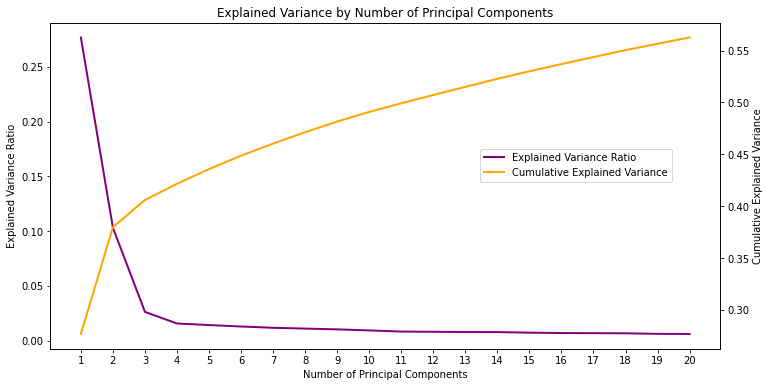

In [45]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import MaxNLocator

PCA_X_RANGE = range(1, N_COMPONENTS + 1)

# Create figure
pca_fig, pca_ax = plt.subplots(figsize=(12, 6))
pca_ax.set_title("Explained Variance by Number of Principal Components")

# Plot explained variance ratio
pca_ax.plot(PCA_X_RANGE,
            pca.explained_variance_ratio_,
            color="purple",
            linewidth=2,
            label="Explained Variance Ratio")
pca_ax.set(xlabel="Number of Principal Components",
           ylabel="Explained Variance Ratio")

pca_ax_cumulative = pca_ax.twinx()
cumulative_explained = np.cumsum(pca.explained_variance_ratio_)
pca_ax_cumulative.plot(PCA_X_RANGE,
                       cumulative_explained,
                       color="orange",
                       linewidth=2,
                       label="Cumulative Explained Variance")
pca_ax_cumulative.set_ylabel("Cumulative Explained Variance")

pca_fig.legend(bbox_to_anchor=(0.85, 0.6))

# Fix x-axis tick labels to show integers
pca_ax.set_xticks(PCA_X_RANGE)
_ = pca_ax.set_xticklabels(PCA_X_RANGE)

In [5]:
from myst_nb import glue

k_3_explained = f"{cumulative_explained[3] * 100:.2f}"

glue("k_3_explained", k_3_explained, display=False)

It seems like the added value of using more than 2 or 3 components is relatively negligible, with 3 components explaining a total of {glue:text}`k_3_explained`% of the total variance. 

To apply the dimensionality reduction to our dataset, we have to call [`tranform()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.transform):

In [37]:
X_reduced = pca.transform(X_scaled)
X_reduced.shape

(463, 20)

```{note}
As with many other classes that implement this general procedure, `sklearn` also provides a [`fit_transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit_transform) function to do both more conveniently.
```

## Model Selection

In [51]:
from sklearn.cluster import KMeans

X_3 = X_reduced[:, :3]
MAX_N_CLUSTERS = 10

models = [KMeans(n_clusters=i).fit(X_3) for i in range(2, MAX_N_CLUSTERS + 1)]

### Clustering Evaluation

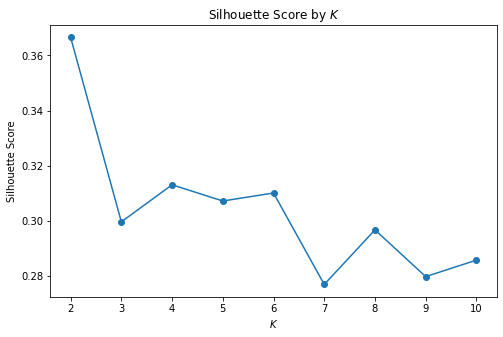

In [68]:
from sklearn.metrics import silhouette_score

scores = [silhouette_score(X_3, model.labels_) for model in models]

scores_fig, scores_ax = plt.subplots(figsize=(8, 5))
scores_ax.plot(range(2, MAX_N_CLUSTERS + 1), scores, "o-")
_ = scores_ax.set(title="Silhouette Score by $k$", xlabel="$k$", ylabel="Silhouette Score")

It seems like the best degree of separation was obtained for $k=2$. Let's visualize the two clusters and to obtain some qualitative understanding of how well our model did:

In [85]:
from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D

x1, x2, x3 = X_3.T


def plot_3d_scatter(elev=0, azim=-90):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(x1, x2, x3, s=15, marker="o", c=models[0].labels_)
    ax.set(xlabel="PC #1", ylabel="PC #2", zlabel="PC #3")
    ax.view_init(elev, azim)

_ = interact(plot_3d_scatter)

interactive(children=(IntSlider(value=0, description='elev', max=1), IntSlider(value=-90, description='azim', …